<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing sale price (Part 2 of 2)

## Problem Statement:

Create a regression model based on the _**Ames Housing Dataset**_. This model will predict the price of a house at sale. <br><br>
Using this model, I would develop a web application where homeowners who wish to sell their property can use to find out what `SalePrice` to sell their property for. The website will have specific fields for visitors to fill and submit details about their property. Using our proprietary machine learning algorithm, the website will generate an estimate visitors can use as reference to quote their property `SalePrice`. <br><br>
**Target audience:** Property listing Proptech companies e.g. PropertyGuru, OhMyHome, SRX

### Contents:
* [Background](#Background)
* [Data Dictionary](#Data-Dictionary)
* [Data Import & Validation](#Data-Import-and-Validation)  
* [Feature selection](#Feature-selection-based-on-correlation-with-SalePrice)
* [Train-Test-Split](#Train-test-split:)
* [Imputation of `Lot Frontage`](#Imputation-of-train-set:)
* [GridSearchCV](#GridSearch-CV)
* [Algorithm](#LassoCV)
* [Multicollinearity](#Multicollinearity-check:)
* [Kaggle Submission](#Kaggle-Submission-preparation)
* [Business case](#Business-case-for-project-2)
* [Summary](#Limitations,-Recommendations-and-Conclusion)

## Background
---

Project 2 involves using a well-known _**Ames housing data**_ to create a regression model that predicts the price of houses in Ames, IA. The Ames Housing Dataset is an exceptionally detailed and robust dataset with over 75 features relating to houses. I am allowed to use any and all features that are present in this dataset. <br><br> This is also a [Kaggle challenge](https://www.kaggle.com/competitions/dsi-us-11-project-2-regression-challenge/overview), so I would need to make at least one submission towards this regression challenge. Kaggle leaderboard standings will be determined by root mean squared error (`RMSE`).

### Data provided
There are 3 datasets included in the [`datasets`](datasets/) folder for this project.
* [`sample_sub_reg.csv`](datasets/sample_sub_reg.csv): An example of a correctly formatted submission for this challenge (with a random number provided as predictions for `SalePrice`). My submission to Kaggle must match this format
* [`test.csv`](datasets/test.csv): Contains the test data for my model. This data is fed into my regression model to make predictions. Target variable (`SalePrice`) is excluded from this data.
* [`train.csv`](datasets/train.csv): Contains all of the training data for my model. 

### Goal
To predict the Sale Price for each house. For each Id in the test set, I must predict the value of the SalePrice.

## Data Dictionary
---
[Link](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

## Data Import and Validation
---

In [1]:
# import modules for data manipulation
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# load data
train_df = pd.read_csv('model_data.csv')

In [3]:
train_df.head(3)

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Alley,Lot Shape,Utilities,Land Slope,Overall Qual,...,htg_other,htg_nan,grge_t_Attchd,grge_t_Detchd,grge_t_other,grge_t_nan,sle_t_Con,sle_t_Oth,sle_t_WD,sle_t_nan
0,109,533352170,60,NaN,13517,0,3,4,3,6,...,0,0,1,0,0,0,0,0,1,0
1,544,531379050,60,43.0,11492,0,3,4,3,7,...,0,0,1,0,0,0,0,0,1,0
2,153,535304180,20,68.0,7922,0,4,4,3,5,...,0,0,0,1,0,0,0,0,1,0


In [4]:
train_df.shape

(1994, 138)

## Feature selection based on correlation with `SalePrice`
---

__Contents:__
1. [Correlation series based on `SalePrice`](#corr_mat)
1. Statistical significance of correlation
    * [Part One](#Statistical-significance-of-correlation:)
    * [Part Two](#Statistical-significance-of-correlation-(cont'd):)

##### corr_mat

In [5]:
# correlation list in relation to SalePrice
corr_mat = train_df.corr().SalePrice.sort_values(ascending=False)
corr_mat.head(18)

SalePrice         1.000000
Overall Qual      0.807923
Exter Qual        0.717032
Gr Liv Area       0.710122
Kitchen Qual      0.688820
Total Bsmt SF     0.656232
Garage Area       0.653884
Garage Cars       0.653081
1st Flr SF        0.640068
Bsmt Qual         0.624507
Year Built        0.599428
Garage Finish     0.567438
Year Remod/Add    0.556784
fdn_PConc         0.548383
Fireplace Qu      0.535294
Full Bath         0.534058
Mas Vnr Area      0.527027
TotRms AbvGrd     0.492471
Name: SalePrice, dtype: float64

In [6]:
# function to distill out the features based on high correlation with `SalePrice`
def corr_list(series, threshold):
    lst = []
    for index, value in series.items():
        if value > threshold:
            lst.append(index)
            
    for item in lst:
        if item == 'SalePrice':
            lst.remove(item)
    return lst

In [7]:
corr_05 = corr_list(corr_mat, threshold=0.5)

In [8]:
len(corr_05)

16

In [9]:
print(corr_05)

['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 'Total Bsmt SF', 'Garage Area', 'Garage Cars', '1st Flr SF', 'Bsmt Qual', 'Year Built', 'Garage Finish', 'Year Remod/Add', 'fdn_PConc', 'Fireplace Qu', 'Full Bath', 'Mas Vnr Area']


I decided to use 0.5 as a correlation threshold to select features that are strongly related to `SalePrice`. This also results in a manageable number of features to fit into my model. There have been other ways of feature selection I have tried (e.g. Lasso model, variation inflation factor scores) but this one seems to result in the best performing model for me. 

##### Statistical significance of correlation:

[Correlation reference](https://stackoverflow.com/questions/41075098/how-to-get-the-p-value-in-a-variable-from-olsresults-in-python)

In [10]:
# calling function to make a list of features from the above correlation pd.Series
# using 0.3 correlation strength as a threshold to include more features for testing
# some strongly correlated features with `SalePrice` may not be statistically significant
corr_03 = corr_list(corr_mat, threshold=0.3)

In [11]:
# need to test for statistical significance
X = train_df[corr_03]
y = train_df['SalePrice']

In [12]:
X.isnull().sum().sort_values(ascending=False)[:3] 
# X has null values that OLS model cannot accept

Lot Frontage     318
Overall Qual       0
TotRms AbvGrd      0
dtype: int64

When I attempted to perform the test for statistical signficance of the correlation between features and `SalePrice`, the test threw an error that X still have null values that needed to be dealt with. So I had to put this test aside until I performed the train-test-split, which is the next step.

## Train-test-split:
---

In [13]:
# import modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
# Create X and y
'''
I would also drop `Id` and `PID` features since they seem to be just serial numbers, 
and are not meaningful in real world setting for predicting sale price
'''
X = train_df.drop(columns=['SalePrice','Id','PID'])
y = train_df['SalePrice']

In [15]:
# create train-test-split sets
# since this is not a classification problem, y cannot be stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
# check X_train for null values, since `Lot Frontage` is not yet imputed
X_train.isnull().sum().sort_values(ascending=False)[:3]

Lot Frontage    235
bdg_t_twnhs       0
cdn_1_nan         0
dtype: int64

## Imputation of train set:
---

KNN imputation will impute all missing values in a dataframe. <br><br>
I have ensured that all other null values in other features have been dealt with, leaving only `Lot Frontage` to be imputed as I wish to keep imputation at the minimum. Sometimes imputed data can exaggerate any bias already present.<br><br>
`Lot Frontage` has a sizable portion of missing values that makes dropping rows sacrificing sizable amount of limited data, but yet not sizable enough (< 50%) that would make imputation impossible or likely inaccurate.<br><br> 

### imp_X_train

In [17]:
# import imputer from sklearn module
from sklearn.impute import KNNImputer

In [18]:
# instantiate imputer
imp = KNNImputer()

In [19]:
'''
fit only X_train, transform both X_train and X_test
create new dataframe variable with the imputed `Lot Frontage` values
'''
imp_X_train = imp.fit_transform(X_train)
imp_X_test = imp.transform(X_test)

In [20]:
imp_X_train = pd.DataFrame(imp_X_train, columns=X_train.columns)
imp_X_test = pd.DataFrame(imp_X_test, columns=X_test.columns)

In [21]:
# no null values left after imputation
print(' imp_X_train '.center(18, "="))
print(imp_X_train.isnull().sum().sort_values(ascending=False)[:3])
print()
print(' imp_X_test '.center(18, '='))
print(imp_X_test.isnull().sum().sort_values(ascending=False)[:3])

== imp_X_train ===
MS SubClass     0
cdn_1_street    0
rf_s_other      0
dtype: int64

=== imp_X_test ===
MS SubClass     0
cdn_1_street    0
rf_s_other      0
dtype: int64


##### Statistical significance of correlation (cont'd):

Now that missing values in `Lot Frontage` has been imputed, I will join the `imp_X_train` with `y_train` into a new dataframe to calculate the statistical significance of correlation between features and `SalePrice`.

In [22]:
imp_X_train.shape

(1395, 135)

In [23]:
imp_X_train.head(3)

,MS SubClass,Lot Frontage,Lot Area,Alley,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,...,htg_other,htg_nan,grge_t_Attchd,grge_t_Detchd,grge_t_other,grge_t_nan,sle_t_Con,sle_t_Oth,sle_t_WD,sle_t_nan
0,160.0,24.0,2645.0,1.0,4.0,4.0,3.0,8.0,5.0,1999.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,90.0,70.0,8267.0,0.0,4.0,4.0,3.0,5.0,5.0,1958.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,20.0,80.0,9600.0,0.0,4.0,4.0,3.0,5.0,6.0,1955.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
y_train.shape

(1395,)

In [25]:
y_train.head(3) 
# notice that y_train indices are not the same as imp_X_train

557     174000
694     135000
1718    144000
Name: SalePrice, dtype: int64

In [26]:
y_train.reset_index(drop=True, inplace=True) 
# reseting y_train indices to match imp_X_train, so that concat is done correctly

In [27]:
# join imp_X_train with y_train to get dataframe to draw correlation
train_set = pd.concat([imp_X_train,y_train], axis=1)

In [28]:
train_set.shape

(1395, 136)

In [29]:
corr_mat2 = train_set.corr().SalePrice.sort_values(ascending=False)
corr_mat2.head(18) 
# notice there is a slight change in rankings after splitting of data,
# and imputation, but not by alot

SalePrice         1.000000
Overall Qual      0.807963
Exter Qual        0.729809
Gr Liv Area       0.694234
Kitchen Qual      0.683729
Total Bsmt SF     0.651156
Garage Area       0.640613
Garage Cars       0.639331
1st Flr SF        0.634253
Bsmt Qual         0.625028
Year Built        0.602364
Garage Finish     0.564189
Year Remod/Add    0.554525
fdn_PConc         0.539754
Fireplace Qu      0.528699
Full Bath         0.524639
Mas Vnr Area      0.510781
grge_t_Attchd     0.493517
Name: SalePrice, dtype: float64

In [30]:
print(corr_03)

['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 'Total Bsmt SF', 'Garage Area', 'Garage Cars', '1st Flr SF', 'Bsmt Qual', 'Year Built', 'Garage Finish', 'Year Remod/Add', 'fdn_PConc', 'Fireplace Qu', 'Full Bath', 'Mas Vnr Area', 'TotRms AbvGrd', 'grge_t_Attchd', 'have_fireplace', 'Heating QC', 'Fireplaces', 'BsmtFin SF 1', 'Bsmt Exposure', 'Lot Frontage', 'ex_1_VinylSd', 'BsmtFin Type 1', 'ex_2_VinylSd', 'Wood Deck SF', 'mvt_Stone', 'Lot Area', 'Open Porch SF']


In [31]:
# testing for statistical significance
X = train_set[corr_03]
y = train_set['SalePrice']

X = sm.add_constant(X, prepend=True)
model_ols = sm.OLS(y, X).fit()

d = {}
for i in X.columns.tolist():
    d[f'{i}'] = model_ols.pvalues[i]

df_pvalue= pd.DataFrame(d.items(), columns=['var_name', 'p-value']).sort_values(by = 'p-value').reset_index(drop=True)

In [32]:
df_pvalue.head(22)

,var_name,p-value
0,Gr Liv Area,2.014785e-36
1,Overall Qual,6.826009e-33
2,BsmtFin SF 1,7.298597e-20
3,Mas Vnr Area,1.823239e-13
4,Exter Qual,1.140672e-12
5,const,4.225537e-10
6,Lot Area,1.020260e-09
7,Bsmt Exposure,2.340634e-07
8,Kitchen Qual,3.749946e-06
9,Fireplace Qu,1.422094e-05


In [33]:
'''
constructed function to distill the features that
had statistically significant correlation with `SalePrice` i.e p-value <0.05
''' 
def pvalue_list(df):
    lst = []
    for feature, pvalue in zip(df['var_name'],df['p-value']):
        if pvalue < 0.05:
            lst.append(feature)
    for item in lst:
        if item == 'const':
            lst.remove(item)
    return lst

In [34]:
print(pvalue_list(df_pvalue))

['Gr Liv Area', 'Overall Qual', 'BsmtFin SF 1', 'Mas Vnr Area', 'Exter Qual', 'Lot Area', 'Bsmt Exposure', 'Kitchen Qual', 'Fireplace Qu', 'mvt_Stone', 'have_fireplace', 'Year Remod/Add', 'Year Built', 'Total Bsmt SF', 'Lot Frontage', 'Garage Area', '1st Flr SF', 'Fireplaces', 'Full Bath', 'BsmtFin Type 1']


In [35]:
len(pvalue_list(df_pvalue))

20

In [36]:
feat_20 = pvalue_list(df_pvalue)

I decided to use this method for feature selection as it provided me the best performing linear model compared to other methods such as VIF or lasso regularisation to help me narrow down the list of useful features.

**This function is to extract the features that were excluded to give the final 20:**

In [37]:
list_1 = train_df.columns.tolist()

In [38]:
def removal_list():
    lst = []
    for x in list_1:
        if x not in feat_20:
            lst.append(x)
    return lst

In [39]:
print(removal_list())
len(removal_list())

['Id', 'PID', 'MS SubClass', 'Alley', 'Lot Shape', 'Utilities', 'Land Slope', 'Overall Cond', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Heating QC', 'Central Air', 'Electrical', '2nd Flr SF', 'Low Qual Fin SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Functional', 'Garage Finish', 'Garage Cars', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Pool QC', 'Fence', 'Misc Feature', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice', 'have_bsmt', 'have_garage', 'have_pool', 'have_fence', 'msz_RL', 'msz_R_others', 'msz_others', 'msz_nan', 'st_Grvl', 'st_Pave', 'st_nan', 'ld_c_Lvl', 'ld_c_unLvl', 'ld_c_nan', 'lt_c_Corner', 'lt_c_Inside', 'lt_c_others', 'lt_c_nan', 'nbrhd_pc_50010', 'nbrhd_pc_50011', 'nbrhd_pc_50014', 'nbrhd_nan', 'cdn_1_Norm', 'cdn_1_feature', 'cdn_1_rail', 'cdn_1_street', 'cdn_1_nan',

118

## GridSearch CV
---

[GridSearch + Pipeline multiple models reference](https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3)

_**Isolate columns desired in X_train**_

In [40]:
X_train_20 = imp_X_train[feat_20]
X_test_20 = imp_X_test[feat_20]

_**Checking range of values for each feature selected for model**_

In [41]:
X_train_20.describe().T

,count,mean,std,min,25%,50%,75%,max
Gr Liv Area,1395.0,1483.713262,455.669035,334.0,1137.5,1440.0,1717.5,3395.0
Overall Qual,1395.0,6.090323,1.377369,1.0,5.0,6.0,7.0,10.0
BsmtFin SF 1,1395.0,428.553405,436.751209,0.0,0.0,353.0,718.0,2188.0
Mas Vnr Area,1395.0,96.497491,163.640902,0.0,0.0,0.0,162.0,1129.0
Exter Qual,1395.0,3.393548,0.591027,2.0,3.0,3.0,4.0,5.0
Lot Area,1395.0,9815.307527,4965.590436,1300.0,7474.0,9399.0,11500.0,70761.0
Bsmt Exposure,1395.0,1.612903,1.070328,0.0,1.0,1.0,2.0,4.0
Kitchen Qual,1395.0,3.501792,0.658650,2.0,3.0,3.0,4.0,5.0
Fireplace Qu,1395.0,1.706810,1.797313,0.0,0.0,0.0,4.0,5.0
mvt_Stone,1395.0,0.083154,0.276214,0.0,0.0,0.0,0.0,1.0


_**Instantiate Pipeline for GridSearchCV, built-in standardisation**_

In [42]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [43]:
# Instantiate a StandardScaler + LR pipeline.
pipe1 = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

# Instantiate a StandardScaler + Ridge pipeline.
pipe2 = Pipeline([
    ('ss', StandardScaler()),
    ('ridge', Ridge())
])

# Instantiate a StandardScaler + LASSO pipeline.
pipe3 = Pipeline([
    ('ss', StandardScaler()),
    ('lasso', Lasso())
])

# Instantiate a StandardScaler + ElasticNet pipeline.
pipe4 = Pipeline([
    ('ss', StandardScaler()),
    ('enet', ElasticNet())
])

In [44]:
# Create dictionary of hyperparameters.
enet_ratio = [.5,.8,.9,.95]
n_neighbors = [3,5,10]
alpha_l = [1.,10.,100.,500.,1000.]

pipe1_params = {'lr__fit_intercept': [True, False],
                'lr__positive': [True, False]
               }

pipe2_params = {'ridge__alpha': alpha_l
               }

pipe3_params = {'lasso__alpha': alpha_l,
                'lasso__max_iter': [10000, 50000]
               }

pipe4_params = {'enet__alpha': alpha_l,
                'enet__l1_ratio': enet_ratio
               }

_**Instantiate GridSearchCV**_

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
cv_ct = 5
score = 'neg_root_mean_squared_error'

pipe1_gs = GridSearchCV(pipe1,
                       pipe1_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

pipe2_gs = GridSearchCV(pipe2,
                       pipe2_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

pipe3_gs = GridSearchCV(pipe3,
                       pipe3_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

pipe4_gs = GridSearchCV(pipe4,
                       pipe4_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

_**Fit models from GridSearchCV pipeline**_

In [47]:
# combine the grids to loop through
grids = [pipe1_gs, pipe2_gs, pipe3_gs, pipe4_gs]

for pipe in grids:
    pipe.fit(X_train_20,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


_**Evaluate models**_

In [48]:
from sklearn.metrics import mean_squared_error

In [49]:
y_bar = np.repeat(np.mean(y_train),(len(y_train)))
y_bar_rmse = mean_squared_error(y_train, y_bar, squared=False)

grid_dict = {0: 'Linear regression', 1: 'Ridge regression',
            2: 'Lasso regression', 3: 'ElasticNet regression'}

for i, model in enumerate(grids):
    print(f'y_bar rmse: {y_bar_rmse}')
    print(f'{grid_dict[i]} train rmse: {model.score(X_train_20, y_train)}')
    print(f'{grid_dict[i]} test rmse: {model.score(X_test_20, y_test)}')
    print(f'{grid_dict[i]} %_diff rmse: {((model.score(X_train_20, y_train)-model.score(X_test_20, y_test))*100)/model.score(X_train_20, y_train)} %')
    print(f'{grid_dict[i]} Best Params: {model.best_params_}')
    print()

y_bar rmse: 75639.33151208214
Linear regression train rmse: -25733.930633227472
Linear regression test rmse: -25591.2380529381
Linear regression %_diff rmse: 0.5544919752955557 %
Linear regression Best Params: {'lr__fit_intercept': True, 'lr__positive': False}

y_bar rmse: 75639.33151208214
Ridge regression train rmse: -25740.51050681656
Ridge regression test rmse: -25568.350841051164
Ridge regression %_diff rmse: 0.6688277053394344 %
Ridge regression Best Params: {'ridge__alpha': 10.0}

y_bar rmse: 75639.33151208214
Lasso regression train rmse: -25733.932248351328
Lasso regression test rmse: -25590.46026412011
Lasso regression %_diff rmse: 0.5575206417993523 %
Lasso regression Best Params: {'lasso__alpha': 1.0, 'lasso__max_iter': 10000}

y_bar rmse: 75639.33151208214
ElasticNet regression train rmse: -25858.738261323208
ElasticNet regression test rmse: -25577.663324275418
ElasticNet regression %_diff rmse: 1.0869630768806386 %
ElasticNet regression Best Params: {'enet__alpha': 1.0, 'e

All my models via GridSearchCV are performing better than baseline despite poor absolute `RMSE` scores. All the models also have good generalisation since the `% diff rsme` scores are all < 5%. I will choose the model with the **best test rmse** for fine tuning. That would be the **Ridge model**.

In [50]:
# function for graphical comparison of predictions vs. actual
def sns_plt(model,x_data,y_data,title):
    sns.set(rc = {'figure.figsize':(5,5)})
    p = sns.regplot(x=model.predict(x_data), y=y_data, marker='.',
               scatter_kws={"color": "steelblue"}, line_kws={"color": "peru"})
    p.set_xlabel("predictions", fontsize = 12)
    p.set_ylabel("actual", fontsize = 12)
    plt.title(title, fontsize=15);
    plt.xticks([0,100000,200000,300000,400000],[0,'100k','200k','300k','400k'])
    plt.yticks([0,100000,200000,300000,400000,500000,600000],[0,'100k','200k','300k','400k','500k','600k']);

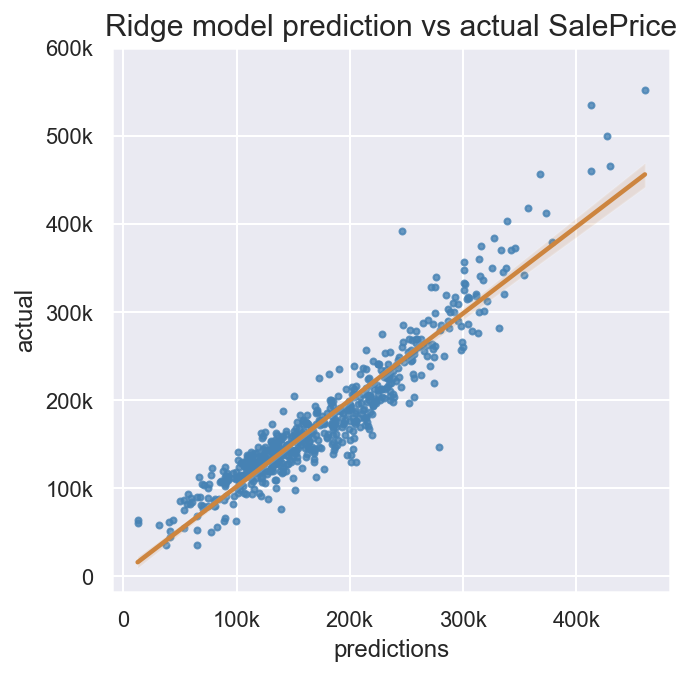

In [51]:
title = 'Ridge model prediction vs actual SalePrice'
sns_plt(model=pipe2_gs, x_data=X_test_20, y_data=y_test, title=title)

Using the 20 features with the highest correlation to `SalePrice`, my first model shows relatively good accuracy for predicting house `SalePrice` \\$400k and below. There is a good linear relationship between the actual and predicted values below \\$400k. 

## RidgeCV
---

_**Fine tuning Ridge model**_

In [52]:
from sklearn.linear_model import RidgeCV

_**Construct Ridge instantiate function**_

In [53]:
def ridge_cv(train, test):
    ss = StandardScaler()  # standardise X_train, X_test
    Z_train = ss.fit_transform(train)
    Z_test = ss.transform(test) 
    
    ######## Ridge cv model ########
    r_alphas = np.logspace(0,5,100) # list of alphas to check
    ridge_cv = RidgeCV(alphas=r_alphas, cv=5, scoring='neg_root_mean_squared_error')
    ridge_cv.fit(Z_train, y_train)
    
    ########
    return ridge_cv

In [54]:
# lasso cv best alpha value
ridge_cv(X_train_20, X_test_20).alpha_

6.42807311728432

##### Evaluate RidgeCV model:

In [55]:
# Constructed function for Ridge model evaluation metrics
def ridge_metrics(model, train, test): 
    y_train_pred = model.predict(train)
    y_test_pred = model.predict(test)

    y_bar = np.repeat(np.mean(y_train),(len(y_train)))
    y_bar_rmse = mean_squared_error(y_train, y_bar, squared=False)

    rmse_train = model.score(train, y_train)
    # mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_test = model.score(test, y_test)
    # mean_squared_error(y_test, y_test_pred, squared=False)
    perc_diff = (rmse_train - rmse_test)/rmse_train * 100

    print(f'y_bar rmse: {y_bar_rmse}')
    print(f'Train rmse: {rmse_train}')
    print(f'Test rmse: {rmse_test}')
    print(f'perc_diff: {perc_diff} %')

In [56]:
model = ridge_cv(X_train_20, X_test_20)

ridge_metrics(model, X_train_20, X_test_20)

y_bar rmse: 75639.33151208214
Train rmse: -2776583.662183867
Test rmse: -2700431.7261218876
perc_diff: 2.7426487124858854 %


C:\Users\Maybelle\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
C:\Users\Maybelle\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
C:\Users\Maybelle\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
C:\Users\Maybelle\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(


Surprisingly, this RidgeCV model has a significantly worse performance than my GridSearchCV Ridge model. This model also is worse performing than baseline. I will choose the GridSearchCV Ridge model **`pipe2_gs`** for making predictions on the [test.csv](./datasets/test.csv).

##  Multicollinearity check:
---

Initially, I used `Variance Inflation Factors`(VIF) to help with feature selection. However it resulted in the exclusion of many features that were highly correlated with `SalePrice` and an eventual poor performing model.<br><br> 
However it is still important to examine the multicollinearity between the features that have been used for the Ridge model **`pipe2_gs`** I have chosen to use on [test.csv](./datasets/test.csv).

My references are:
* [Multicollinearity in regression](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)
* [VIF](https://statisticsbyjim.com/regression/variance-inflation-factors/)
* [Multicollinearity with VIF](https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/)
* [Add constant in VIF calculation](https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python)

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [58]:
'''
to show all columns for null values assessment. 
Default only showed top 5 and bottom 5 columns
''' 
pd.options.display.min_rows = 20

In [59]:
def vif_scores(df):
    X = df.assign(const=1) # add a constant
    
    vif_data = pd.DataFrame()  # initiate VIF dataframe
    vif_data["feature"] = X.columns
    
    vif_data["vif"] = sorted([  # sort to show values with highest VIF scores
        variance_inflation_factor(X.values, i) # calculate VIF for each feature
        for i in range(len(X.columns))], reverse=True) 
    
    return vif_data

In [60]:
vif_df = vif_scores(X_train_20)

In [61]:
print(vif_df)

           feature           vif
0      Gr Liv Area  20486.869948
1     Overall Qual     17.869798
2     BsmtFin SF 1     12.615395
3     Mas Vnr Area      7.695555
4       Exter Qual      3.592153
5         Lot Area      3.457068
6    Bsmt Exposure      3.397382
7     Kitchen Qual      3.233269
8     Fireplace Qu      2.647413
9        mvt_Stone      2.642132
10  have_fireplace      2.585894
11  Year Remod/Add      2.581521
12      Year Built      2.362629
13   Total Bsmt SF      2.171844
14    Lot Frontage      2.124630
15     Garage Area      1.888327
16      1st Flr SF      1.682331
17      Fireplaces      1.648372
18       Full Bath      1.374341
19  BsmtFin Type 1      1.373617
20           const      1.231542


There is high multicollinearity between `Overall Qual`,`Gr Liv Area`,`BsmtFin SF 1` and the other features used in my model. I am also aware that `Overall Qual` and `Gr Liv Area` are the most correlated features to `SalePrice`, so removing them from my model would reduce the performance significantly. Because of that, I will let them remain in my model.

In [62]:
# imp_X_train + y_train = train_set
train_set[feat_20].head(3)

,Gr Liv Area,Overall Qual,BsmtFin SF 1,Mas Vnr Area,Exter Qual,Lot Area,Bsmt Exposure,Kitchen Qual,Fireplace Qu,mvt_Stone,have_fireplace,Year Remod/Add,Year Built,Total Bsmt SF,Lot Frontage,Garage Area,1st Flr SF,Fireplaces,Full Bath,BsmtFin Type 1
0,1441.0,8.0,0.0,456.0,4.0,2645.0,1.0,4.0,0.0,0.0,0.0,2000.0,1999.0,776.0,24.0,492.0,764.0,0.0,2.0,1.0
1,1604.0,5.0,0.0,0.0,3.0,8267.0,1.0,3.0,0.0,0.0,0.0,1958.0,1958.0,1604.0,70.0,576.0,1604.0,0.0,2.0,1.0
2,1150.0,5.0,368.0,176.0,3.0,9600.0,1.0,3.0,0.0,0.0,0.0,1955.0,1955.0,1078.0,80.0,288.0,1150.0,0.0,1.0,4.0


In [63]:
# Create correlation matrix from train data excluding `SalePrice`
def corr_heatmap(df, size):  
    corr_df = df.corr()

    # Show only correlations greater than 0.5
    corr = corr_df[abs(corr_df) >= 0.5]

    # apply masking
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    # Plot correlation heatmap
    plt.figure(figsize=size)
    sns.heatmap(corr,
                annot=True,
                fmt='.1f',
                cmap='GnBu',
                mask=mask,
                vmin=0.5,
                vmax=1)
    title = plt.title('Correlation Heatmap')

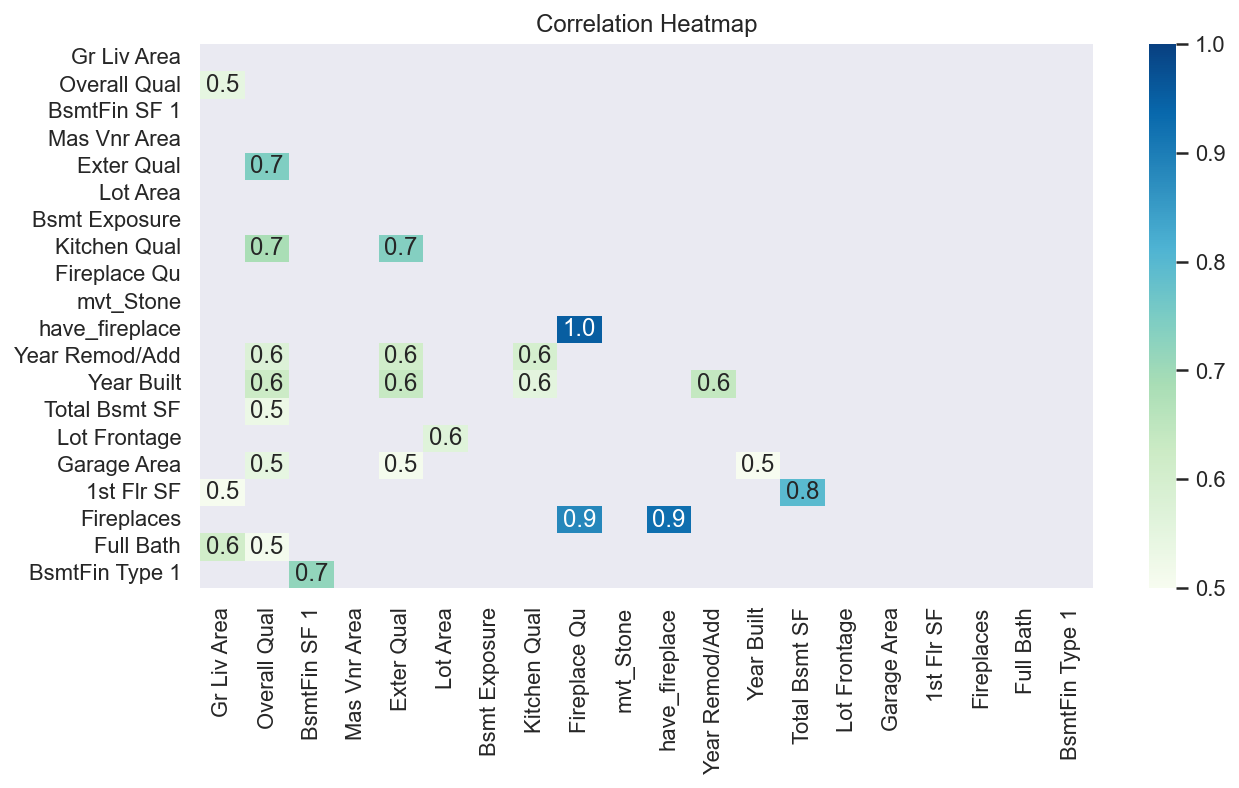

In [64]:
corr_heatmap(df=train_set[feat_20], size=(10,5))

There is multicollinearity between many features. The features with highest correlations are:
* `Fireplace Qu` and `Fireplaces` and `have_fireplace`
* `Total Bsmt SF` and `1st Flr SF`

In [65]:
corr_train = train_set.corr().SalePrice.sort_values(ascending=False)
corr_train.head(19)

SalePrice         1.000000
Overall Qual      0.807963
Exter Qual        0.729809
Gr Liv Area       0.694234
Kitchen Qual      0.683729
Total Bsmt SF     0.651156
Garage Area       0.640613
Garage Cars       0.639331
1st Flr SF        0.634253
Bsmt Qual         0.625028
Year Built        0.602364
Garage Finish     0.564189
Year Remod/Add    0.554525
fdn_PConc         0.539754
Fireplace Qu      0.528699
Full Bath         0.524639
Mas Vnr Area      0.510781
grge_t_Attchd     0.493517
Fireplaces        0.480549
Name: SalePrice, dtype: float64

The features with the highest correlations with `SalePrice` also tend to share multicollinearity with each other. Multicollinearity usually have a negative impact on prediction models, I attempted to reduce multicollinearity by removing the following features...
* `BsmtFin SF 1`
* `Fireplaces`  
* `have_fireplace` 

based on them having lower correlation scores with `SalePrice` compared to `Fireplace Qu`. `BsmtFin SF 1` is removed due to high VIF score. I am reluctant to drop `1st Flr SF` due to its relatively high correlation with `SalePrice`. If I drop too many features, it will compromise on the model performance significantly. I am also dropping `Lot Frontage` because this feature had a high percentage of missing values and might introduce additional bias to model from imputation. <br><br> This resulted in a slightly poorer performing model but maintained a good level of generalisation with `RSME` percentage difference between train and test sets of <5%. Hence I would move forward with the 16 features in `X_train_16`.

In [66]:
X_train_16 = X_train_20.drop(columns=['BsmtFin SF 1','Fireplaces','have_fireplace','Lot Frontage'])
X_test_16 = X_test_20.drop(columns=['BsmtFin SF 1','Fireplaces','have_fireplace','Lot Frontage'])

In [67]:
# Instantiate a StandardScaler + LR pipeline.
pipe5 = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

# Instantiate a StandardScaler + Ridge pipeline.
pipe6 = Pipeline([
    ('ss', StandardScaler()),
    ('ridge', Ridge())
])

# Instantiate a StandardScaler + LASSO pipeline.
pipe7 = Pipeline([
    ('ss', StandardScaler()),
    ('lasso', Lasso())
])

# Instantiate a StandardScaler + ElasticNet pipeline.
pipe8 = Pipeline([
    ('ss', StandardScaler()),
    ('enet', ElasticNet())
])

In [68]:
# Create dictionary of hyperparameters.
enet_ratio = [.5,.8,.9,.95]
n_neighbors = [3,5,10]
alpha_l = [1.,10.,100.,500.,1000.]

pipe5_params = {'lr__fit_intercept': [True, False],
                'lr__positive': [True, False]
               }

pipe6_params = {'ridge__alpha': alpha_l
               }

pipe7_params = {'lasso__alpha': alpha_l,
                'lasso__max_iter': [10000, 50000]
               }

pipe8_params = {'enet__alpha': alpha_l,
                'enet__l1_ratio': enet_ratio
               }

_**Instantiate GridSearchCV**_

In [69]:
from sklearn.model_selection import GridSearchCV

In [70]:
cv_ct = 5
score = 'neg_root_mean_squared_error'

pipe5_gs = GridSearchCV(pipe5,
                       pipe5_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

pipe6_gs = GridSearchCV(pipe6,
                       pipe6_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

pipe7_gs = GridSearchCV(pipe7,
                       pipe7_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

pipe8_gs = GridSearchCV(pipe8,
                       pipe8_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

_**Fit models from GridSearchCV pipeline**_

In [71]:
# combine the grids to loop through
grids = [pipe5_gs, pipe6_gs, pipe7_gs, pipe8_gs]

for pipe in grids:
    pipe.fit(X_train_16,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


_**Evaluate models**_

In [72]:
from sklearn.metrics import mean_squared_error

In [73]:
y_bar = np.repeat(np.mean(y_train),(len(y_train)))
y_bar_rmse = mean_squared_error(y_train, y_bar, squared=False)

grid_dict = {0: 'Linear regression', 1: 'Ridge regression',
            2: 'Lasso regression', 3: 'ElasticNet regression'}

for i, model in enumerate(grids):
    print(f'y_bar rmse: {y_bar_rmse}')
    print(f'{grid_dict[i]} train rmse: {model.score(X_train_16, y_train)}')
    print(f'{grid_dict[i]} test rmse: {model.score(X_test_16, y_test)}')
    print(f'{grid_dict[i]} %_diff rmse: {((model.score(X_train_16, y_train)-model.score(X_test_16, y_test))*100)/model.score(X_train_16, y_train)} %')
    print(f'{grid_dict[i]} Best Params: {model.best_params_}')
    print()

y_bar rmse: 75639.33151208214
Linear regression train rmse: -26765.703031092587
Linear regression test rmse: -26676.536266571886
Linear regression %_diff rmse: 0.3331381373286568 %
Linear regression Best Params: {'lr__fit_intercept': True, 'lr__positive': False}

y_bar rmse: 75639.33151208214
Ridge regression train rmse: -26766.963445522935
Ridge regression test rmse: -26666.102720741696
Ridge regression %_diff rmse: 0.37681048500893644 %
Ridge regression Best Params: {'ridge__alpha': 10.0}

y_bar rmse: 75639.33151208214
Lasso regression train rmse: -26765.70321835631
Lasso regression test rmse: -26676.403472444876
Lasso regression %_diff rmse: 0.33363497003206305 %
Lasso regression Best Params: {'lasso__alpha': 1.0, 'lasso__max_iter': 10000}

y_bar rmse: 75639.33151208214
ElasticNet regression train rmse: -26814.12399508294
ElasticNet regression test rmse: -26652.05110676893
ElasticNet regression %_diff rmse: 0.6044310391931176 %
ElasticNet regression Best Params: {'enet__alpha': 1.0,

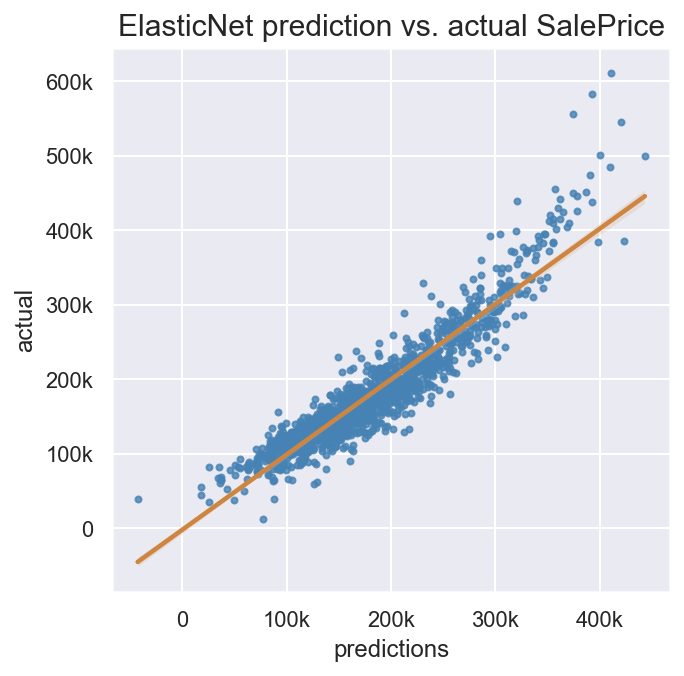

In [74]:
title = 'ElasticNet prediction vs. actual SalePrice'
sns_plt(model=pipe8_gs, x_data=X_train_16, y_data=y_train, title=title)

After dropping 4 features that have high multicollinearity VIF scores and high correlation scores, the general performance metrics have dropped slightly, which is expected since features are removed. The models still have good generalisation of <5% `RMSE` difference. <br><br>
This time, it is ElasticNet model **`pipe8_gs`** that has the best `test RMSE` scores. I will attempt to finetune the ElasticNet model below.

## ElasticNetCV
---

_**Fine tuning ElasticNet model**_

In [75]:
pipe_enet = Pipeline([
    ('ss', StandardScaler()),
    ('enet', ElasticNet())
])

In [76]:
# Create dictionary of hyperparameters.
enet_ratio = np.linspace(0.5, 1.0, 100)
alpha_l = np.linspace(0.5, 1.0, 10)

pipe_enet_params = {'enet__alpha': alpha_l,
                    'enet__l1_ratio': enet_ratio
                   }

_**Instantiate GridSearchCV**_

In [77]:
cv_ct = 5
score = 'neg_root_mean_squared_error'

pipe_enet_gs = GridSearchCV(pipe_enet,
                       pipe_enet_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

_**Fit models from GridSearchCV pipeline**_

In [78]:
pipe_enet_gs.fit(X_train_16,y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('enet', ElasticNet())]),
             param_grid={'enet__alpha': array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ]),
                         'enet__l1_ratio': array([0.5       , 0.50505051, 0.51010101, 0.51515152, 0.52020202,
       0.52525253, 0.53030303, 0.53535354, 0.54040404, 0.54545455,
       0...
       0.85353535, 0.85858586, 0.86363636, 0.86868687, 0.87373737,
       0.87878788, 0.88383838, 0.88888889, 0.89393939, 0.8989899 ,
       0.9040404 , 0.90909091, 0.91414141, 0.91919192, 0.92424242,
       0.92929293, 0.93434343, 0.93939394, 0.94444444, 0.94949495,
       0.95454545, 0.95959596, 0.96464646, 0.96969697, 0.97474747,
       0.97979798, 0.98484848, 0.98989899, 0.99494949, 1.        ])},
             scoring='neg_root_mean_squared_error', verbose=1)

_**Evaluate model**_

In [79]:
y_bar = np.repeat(np.mean(y_train),(len(y_train)))
y_bar_rmse = mean_squared_error(y_train, y_bar, squared=False)

print(f'y_bar rmse: {y_bar_rmse}')
print(f'ElasticNet train rmse: {pipe_enet_gs.score(X_train_16, y_train)}')
print(f'ElasticNet test rmse: {pipe_enet_gs.score(X_test_16, y_test)}')
print(f'ElasticNet %_diff rmse: {((pipe_enet_gs.score(X_train_16, y_train)-pipe_enet_gs.score(X_test_16, y_test))*100)/pipe_enet_gs.score(X_train_16, y_train)} %')
print(f'ElasticNet Best Params: {pipe_enet_gs.best_params_}')
print()

y_bar rmse: 75639.33151208214
ElasticNet train rmse: -26767.02204581697
ElasticNet test rmse: -26665.865402276253
ElasticNet %_diff rmse: 0.37791519492743425 %
ElasticNet Best Params: {'enet__alpha': 0.7222222222222222, 'enet__l1_ratio': 0.98989898989899}



##### Reference `pipe8_gs` performance metrics: 

Fine tuning the ElasticNet model using GridSearchCV resulted in a model that achieved a better `train rmse` score but a slightly worse `test rmse` score. Therefore, I will use the ElasticNet model **`pipe8_gs`** from the previous GridSearchCV for [test.csv](./datasets/test.csv) predictions.

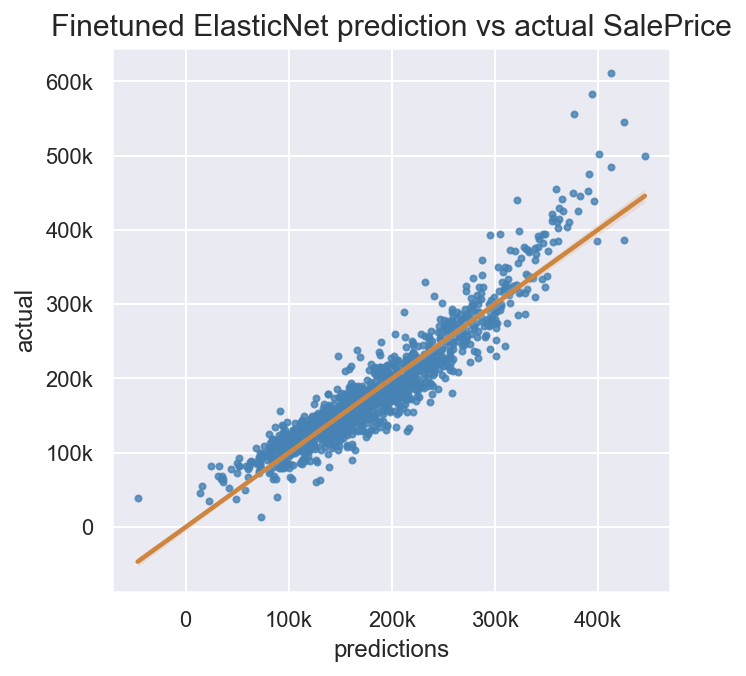

In [80]:
title = 'Finetuned ElasticNet prediction vs actual SalePrice'
sns_plt(model=pipe_enet_gs, x_data=X_train_16, y_data=y_train, title=title)

My model does not work well to predict `SalePrice` above \\$400k.

## Kaggle Submission preparation
---

**Contents:**
* [Original test set](#test_df)
* [Dummified test set](#test_dum)
* [Features isolated and imputed test set](#imp_test)
* [Make predictions](#Make-predictions-using-ElasticNet-Model-from-GridSearchCV)

### test_df

_Import [test.csv](./datasets/test.csv)_

In [81]:
# use test.csv to generate predictions for submission
test_df = pd.read_csv('./datasets/test.csv')

In [82]:
test_df.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New


_Dummify test_df and resolve any null values before getting prediction values because of model restrictions_

In [83]:
'''
Final features to isolate in test set so that model can accept test data to make predictions
'''
print(X_train_16.columns.tolist())
len(X_train_16.columns.tolist())

['Gr Liv Area', 'Overall Qual', 'Mas Vnr Area', 'Exter Qual', 'Lot Area', 'Bsmt Exposure', 'Kitchen Qual', 'Fireplace Qu', 'mvt_Stone', 'Year Remod/Add', 'Year Built', 'Total Bsmt SF', 'Garage Area', '1st Flr SF', 'Full Bath', 'BsmtFin Type 1']


16

Need to group and label the categorical values the same way I did for the training data. Features to focus on are `Exter Qual`, `Bsmt Exposure`, `Kitchen Qual`, `Fireplace Qu`, `mvt_Stone`,`BsmtFin Type 1`.

##### Instantiate functions used for ordinal encoding of training data:

In [84]:
def int_rank3(df,col,var_no):
    return df[col].replace({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, var_no:0}, inplace=True)

In [85]:
def int_rank1(df,col):
    return df[col].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}, inplace=True)

In [86]:
def int_rank2(df,col,var_no):
    return df[col].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, var_no:0}, inplace=True)

##### Apply functions:

In [87]:
# BsmtFin Type 1
int_rank3(test_df,col='BsmtFin Type 1',var_no=np.nan)

In [88]:
#Bsmt Exposure
test_df['Bsmt Exposure'].replace({'Gd':4, 'Av':3, 'Mn':2, 'No':1, np.nan:0}, inplace=True)

In [89]:
#mvt_Stone
test_df['Mas Vnr Type'].replace({'BrkCmn':'other', np.nan:'other',
                                  'None':'other', 'CBlock':'other'
                              }, inplace=True)
# check changes
test_df['Mas Vnr Type'].value_counts()

other      548
BrkFace    250
Stone       80
Name: Mas Vnr Type, dtype: int64

In [90]:
# label encode these categorical features to ordinal numerical values
int_rank1(test_df, col='Exter Qual')
int_rank1(test_df, col='Kitchen Qual')
int_rank2(test_df,col='Fireplace Qu',var_no=np.nan)

### test_dum

Dummify the desired categorical features in the test set.

In [91]:
prefix_dict = {'Mas Vnr Type': 'mvt'}

columns_list = ['Mas Vnr Type']

test_dum = pd.get_dummies(data=test_df, prefix=prefix_dict, dummy_na=True, columns=columns_list)
test_dum.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,mvt_BrkFace,mvt_Stone,mvt_other,mvt_nan
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,NaN,NaN,0,4,2006,WD,0,0,1,0
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,8,2006,WD,0,0,1,0
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,9,2006,New,0,0,1,0


In [92]:
test_select = test_dum[X_train_16.columns.tolist()]

In [93]:
# check for null values
test_select.isnull().sum().sort_values(ascending=False)[:3]

Mas Vnr Area    1
Gr Liv Area     0
Overall Qual    0
dtype: int64

### imp_test

I am not allowed to drop any rows. So I will have to do KNN imputation for the missing value in `Mas Vnr Area` in `test_select`.

In [94]:
# instantiate KNN imputer
imp = KNNImputer()

In [95]:
# use KNNImputer fitted on X_train_16, transform test set (matched features)
imp_16 = imp.fit(X_train_16)
imp_test = imp_16.transform(test_select)

In [96]:
# convert to dataframe format
imp_test = pd.DataFrame(imp_test, columns=test_select.columns)

In [97]:
# relook at what null values that are left 
imp_test.isnull().sum().sort_values(ascending=False)[:3]

Gr Liv Area     0
Overall Qual    0
Mas Vnr Area    0
dtype: int64

In [98]:
imp_test.shape

(878, 16)

### Make predictions using ElasticNet Model from GridSearchCV

In [99]:
# generate predictions using the GridsearchCV ElasticNet model fitted on the training set
test_pred = pipe8_gs.predict(imp_test)
len(test_pred)

878

In [100]:
# isolate `Id` column from test_df
test_final = test_df[['Id']]
test_final.head(3)

,Id
0,2658
1,2718
2,2414


In [101]:
'''
predictions are in a list format. 
Need to make new column to input prediction values 
'''
test_final['SalePrice'] = test_pred
test_final.head(3)

C:\Users\Maybelle\AppData\Local\Temp\ipykernel_19744\2170739544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_final['SalePrice'] = test_pred


,Id,SalePrice
0,2658,136381.044108
1,2718,185275.599532
2,2414,221235.124658


In [102]:
# Export file for submission
test_final.to_csv('./kaggle_submission.csv', index=False)

>**User:** yxmauw <br>
**Kaggle score achieved:** 34012.46876 <br>
**Private score:** 27865.38616

## Business case for project 2
---

To develop a web application where homeowners who wish to sell their property can use to find out what `SalePrice` to sell their property for. The webpage will have specific fields for visitors to fill and submit details about their property. Using our proprietary machine learning algorithm, the application will generate an estimate visitors can use as reference to quote their property `SalePrice`. 

__Steps taken:__
1. [Find common features](#Find-common-features-used-in-all-group-members'-models:)
1. [Find group model](#Group-work-model:)
1. [Polynomial feature engineering](#Polynomial-feature-engineering-to-see-if-it-makes-pipe8_gs-model-more-accurate)
1. [Evaluate model for deployment](#Evaluate-model-performance-for-deployment:) <br>
[Multicollinearity check](#Evaluate-for-Multicollinearity:)
1. [Set up web application](#Set-up-data-file-for-model-training-in-Streamlit-web-application:)

##### Find common features used in all group members' models:

In [103]:
my_list = X_train_16.columns.tolist()
print(my_list)

['Gr Liv Area', 'Overall Qual', 'Mas Vnr Area', 'Exter Qual', 'Lot Area', 'Bsmt Exposure', 'Kitchen Qual', 'Fireplace Qu', 'mvt_Stone', 'Year Remod/Add', 'Year Built', 'Total Bsmt SF', 'Garage Area', '1st Flr SF', 'Full Bath', 'BsmtFin Type 1']


In [104]:
tiek_leong_features = ['MS Zoning', 'Wood Deck SF', 'Garage Finish', 'Exterior 1st',
                       'Bsmt Full Bath', 'TotRms AbvGrd', 'Lot Frontage', 'Fireplace Qu',
                       'Neighborhood', 'Lot Area', 'Garage Area', 'Bsmt Exposure',
                       'Overall Cond', 'Kitchen Qual', 'Exter Qual', 'Mas Vnr Area',
                       'Total Bsmt SF', 'Year Built', 'BsmtFin SF 1', '1st Flr SF',
                       '2nd Flr SF', 'Gr Liv Area', 'Overall Qual']

In [105]:
anand_features = ['Overall Qual','Gr Liv Area','Total Bsmt SF',  
                   'Garage Area','Year Built','Year Remod/Add','fdn_PConc', 
                   'Mas Vnr Area','Fireplaces','bsmtfin_type_1_gq']

To refine the features for our machine learning algorithm, we find the features that are present in all 3 group members final model feature selection.

In [106]:
def common_features(lst_1, lst_2, lst_3):
    lst = []
    for x in lst_1:
        for y in lst_2:
            for z in lst_3:
                if x==y==z:
                    lst.append(x)
    return lst

In [107]:
com_list = common_features(my_list, tiek_leong_features, anand_features)
print(com_list)

['Gr Liv Area', 'Overall Qual', 'Mas Vnr Area', 'Year Built', 'Total Bsmt SF', 'Garage Area']


There are 6 features that are common across all 3 group members final model feature selection. 
However, 1 out of the 6 features is quite subjective for visitors to fill in on the website. Therefore, I decided that for any new data from the website, `Overall Qual` will be imputed based on KNNImputer fitted on training data and fed to the algorithm to generate a prediction.

##### Group work model:

In [108]:
grp_X_train = imp_X_train[com_list]
grp_X_test = imp_X_test[com_list]

In [109]:
# Instantiate a StandardScaler + LR pipeline.
pipe9 = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

# Instantiate a StandardScaler + Ridge pipeline.
pipe10 = Pipeline([
    ('ss', StandardScaler()),
    ('ridge', Ridge())
])

# Instantiate a StandardScaler + LASSO pipeline.
pipe11 = Pipeline([
    ('ss', StandardScaler()),
    ('lasso', Lasso())
])

# Instantiate a StandardScaler + ElasticNet pipeline.
pipe12 = Pipeline([
    ('ss', StandardScaler()),
    ('enet', ElasticNet())
])

In [110]:
# Create dictionary of hyperparameters.
enet_ratio = [.5,.8,.9,.95]
n_neighbors = [3,5,10]
alpha_l = [1.,10.,100.,500.,1000.]

pipe9_params = {'lr__fit_intercept': [True, False],
                'lr__positive': [True, False]
               }

pipe10_params = {'ridge__alpha': alpha_l
               }

pipe11_params = {'lasso__alpha': alpha_l,
                'lasso__max_iter': [10000, 50000]
               }

pipe12_params = {'enet__alpha': alpha_l,
                'enet__l1_ratio': enet_ratio
               }

In [111]:
cv_ct = 5
score = 'neg_root_mean_squared_error'

pipe9_gs = GridSearchCV(pipe9,
                       pipe9_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

pipe10_gs = GridSearchCV(pipe10,
                       pipe10_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

pipe11_gs = GridSearchCV(pipe11,
                       pipe11_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

pipe12_gs = GridSearchCV(pipe12,
                       pipe12_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

In [112]:
# combine the grids to loop through
grids = [pipe9_gs, pipe10_gs, pipe11_gs, pipe12_gs]

for pipe in grids:
    pipe.fit(grp_X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


_**Evaluate models**_

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [114]:
y_bar = np.repeat(np.mean(y_train),(len(y_train)))
y_bar_rmse = mean_squared_error(y_train, y_bar, squared=False)

grid_dict = {0: 'Linear regression', 1: 'Ridge regression',
            2: 'Lasso regression', 3: 'ElasticNet regression'}

for i, model in enumerate(grids):
    print(f'y_bar rmse: {y_bar_rmse}')
    print(f'{grid_dict[i]} train mae: {mean_absolute_error(y_train, model.predict(grp_X_train))}')
    print(f'{grid_dict[i]} test mae: {mean_absolute_error(y_test, model.predict(grp_X_test))}')
    print(f'{grid_dict[i]} train rmse: {model.score(grp_X_train, y_train)}')
    print(f'{grid_dict[i]} test rmse: {model.score(grp_X_test, y_test)}')
    print(f'{grid_dict[i]} %_diff rmse: {((model.score(grp_X_train, y_train)-model.score(grp_X_test, y_test))*100)/model.score(grp_X_train, y_train)} %')
    print(f'{grid_dict[i]} Best Params: {model.best_params_}')
    print()

y_bar rmse: 75639.33151208214
Linear regression train mae: 22695.410599127823
Linear regression test mae: 23191.803844300954
Linear regression train rmse: -31226.91644214323
Linear regression test rmse: -30879.880640007053
Linear regression %_diff rmse: 1.111335481295946 %
Linear regression Best Params: {'lr__fit_intercept': True, 'lr__positive': True}

y_bar rmse: 75639.33151208214
Ridge regression train mae: 22665.42227295901
Ridge regression test mae: 23147.405502301244
Ridge regression train rmse: -31227.645944263808
Ridge regression test rmse: -30850.786708804808
Ridge regression %_diff rmse: 1.206812822624003 %
Ridge regression Best Params: {'ridge__alpha': 10.0}

y_bar rmse: 75639.33151208214
Lasso regression train mae: 22676.892668025976
Lasso regression test mae: 23165.361614715126
Lasso regression train rmse: -31227.237925192356
Lasso regression test rmse: -30864.621227045707
Lasso regression %_diff rmse: 1.1612192503715164 %
Lasso regression Best Params: {'lasso__alpha': 100

For the ease of interpretation by users of the website, we will be using mean absolute error(MAE) as the range of error to include in our `SalePrice` predictions when displaying the `SalePrice` quote to users. 

Therefore, the best linear model based on lowest MAE score is `ElasticNet`, which I will attempt to fine tune, before deploying to the web application.

#### Finetune ElasticNet model `pipe12_gs` for deployment: 

In [115]:
enet_ratio = np.linspace(.5,1,50)
alpha_l = np.linspace(.01,1,50)

pipe_enet2 = Pipeline([
    ('ss', StandardScaler()),
    ('enet', ElasticNet())
])

pipe_enet2_params = {'enet__alpha': alpha_l,
                'enet__l1_ratio': enet_ratio
               }

In [116]:
cv_ct = 5
score = 'neg_root_mean_squared_error'

pipe_enet2_gs = GridSearchCV(pipe_enet2,
                       pipe_enet2_params,
                       cv=cv_ct,
                       scoring=score,
                       verbose=1
                       )

In [117]:
pipe_enet2_gs.fit(grp_X_train,y_train)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('enet', ElasticNet())]),
             param_grid={'enet__alpha': array([0.01      , 0.03020408, 0.05040816, 0.07061224, 0.09081633,
       0.11102041, 0.13122449, 0.15142857, 0.17163265, 0.19183673,
       0.21204082, 0.2322449 , 0.25244898, 0.27265306, 0.29285714,
       0.31306122, 0.33326531, 0.35346939, 0.37367347, 0.39387755,
       0.41408163, 0...
       0.70408163, 0.71428571, 0.7244898 , 0.73469388, 0.74489796,
       0.75510204, 0.76530612, 0.7755102 , 0.78571429, 0.79591837,
       0.80612245, 0.81632653, 0.82653061, 0.83673469, 0.84693878,
       0.85714286, 0.86734694, 0.87755102, 0.8877551 , 0.89795918,
       0.90816327, 0.91836735, 0.92857143, 0.93877551, 0.94897959,
       0.95918367, 0.96938776, 0.97959184, 0.98979592, 1.        ])},
             scoring='neg_root_mean_squared_error', verbose=1)

In [118]:
y_bar = np.repeat(np.mean(y_train),(len(y_train)))
y_bar_rmse = mean_squared_error(y_train, y_bar, squared=False)

print(f'y_bar rmse: {y_bar_rmse}')
print(f'Elastic Net train mae: {mean_absolute_error(y_train, pipe_enet2_gs.predict(grp_X_train))}')
print(f'Elastic Net test mae: {mean_absolute_error(y_test, pipe_enet2_gs.predict(grp_X_test))}')
print(f'Elastic Net train rmse: {pipe_enet2_gs.score(grp_X_train, y_train)}')
print(f'Elastic Net test rmse: {pipe_enet2_gs.score(grp_X_test, y_test)}')
print(f'Elastic Net %_diff rmse: {((pipe_enet2_gs.score(grp_X_train, y_train)-pipe_enet2_gs.score(grp_X_test, y_test))*100)/pipe_enet2_gs.score(grp_X_train, y_train)} %')
print(f'Elastic Net Best Params: {pipe_enet2_gs.best_params_}')

y_bar rmse: 75639.33151208214
Elastic Net train mae: 22644.64861550354
Elastic Net test mae: 23116.579566649707
Elastic Net train rmse: -31229.047971307307
Elastic Net test rmse: -30831.16411527073
Elastic Net %_diff rmse: 1.2740825669810532 %
Elastic Net Best Params: {'enet__alpha': 0.030204081632653063, 'enet__l1_ratio': 0.5918367346938775}


Reference **`pipe12_gs`** score metrics:

Unfortunately, the fine tuning using just ElasticNet within GridSearchCV did not result in a better MAE score compared to **`pipe12_gs`**. Therefore I will use **`pipe12_gs`** as the model to deploy in the website.

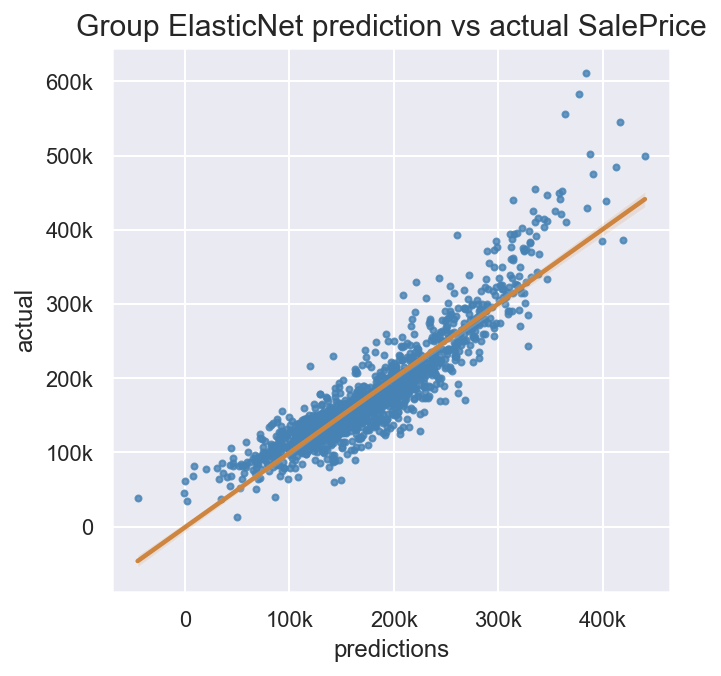

In [119]:
title = 'Group ElasticNet prediction vs actual SalePrice'
sns_plt(model=pipe_enet2_gs, x_data=grp_X_train, y_data=y_train, title=title)

The first model constructed using the common group features still shows poor prediction capability for house `SalePrice` above \\$400k.

##### Polynomial feature engineering to see if it makes `pipe12_gs` model more accurate

In [120]:
from sklearn.preprocessing import PolynomialFeatures

In [121]:
grp_X_train.shape

(1395, 6)

In [122]:
grp_X_test.shape

(599, 6)

In [123]:
y_test.reset_index(drop=True, inplace=True) # to align with grp_X_test indices

In [124]:
# combine data to check for correlation ranking
model_train = pd.concat([grp_X_train,y_train], axis=1)
model_test = pd.concat([grp_X_test,y_test], axis=1)

In [125]:
model_data = pd.concat([model_train,model_test], axis=0)

In [126]:
model_data.shape

(1994, 7)

In [127]:
# rank correlation
model_data.corr().SalePrice.sort_values(ascending=False)

SalePrice        1.000000
Overall Qual     0.807923
Gr Liv Area      0.710122
Total Bsmt SF    0.656232
Garage Area      0.653884
Year Built       0.599428
Mas Vnr Area     0.527027
Name: SalePrice, dtype: float64

In [128]:
# Instantiate PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)

In [129]:
# fit and transform data
X_poly_train = poly.fit_transform(grp_X_train[['Gr Liv Area']])
X_poly_test = poly.transform(grp_X_test[['Gr Liv Area']])

I decided to choose `Gr Liv Area` for polynomial feature engineering because its correlation factor with `SalePrice` is 0.7-0.9 (implies strong relationship). I did not choose `Overall Qual` for polynomial feature engineering because as mentioned [earlier](#Find-common-features-used-in-all-group-members'-models:), this feature would become imputed for future new data entered in the web application, and I do not wish to increase the influence of imputed data fed into the model. <br><br> I also attempted to do polynomial feature engineering for features with correlation strength between 0.6 and 0.7, however it caused the model to become overfitted on the training data, and less generalised. 

In [130]:
# convert to pd.dataframe
X_poly_train = pd.DataFrame(X_poly_train, columns=poly.get_feature_names_out(['Gr Liv Area']))
X_poly_test = pd.DataFrame(X_poly_test, columns=poly.get_feature_names_out(['Gr Liv Area']))

In [131]:
# join with original dataframe
X_poly_train = pd.concat([X_poly_train, grp_X_train], axis=1)
X_poly_train.head(3)

,Gr Liv Area,Gr Liv Area^2,Gr Liv Area^3,Gr Liv Area,Overall Qual,Mas Vnr Area,Year Built,Total Bsmt SF,Garage Area
0,1441.0,2076481.0,2.992209e+09,1441.0,8.0,456.0,1999.0,776.0,492.0
1,1604.0,2572816.0,4.126797e+09,1604.0,5.0,0.0,1958.0,1604.0,576.0
2,1150.0,1322500.0,1.520875e+09,1150.0,5.0,176.0,1955.0,1078.0,288.0


In [132]:
# join with original dataframe
X_poly_test = pd.concat([X_poly_test, grp_X_test], axis=1)
X_poly_test.head(3)

,Gr Liv Area,Gr Liv Area^2,Gr Liv Area^3,Gr Liv Area,Overall Qual,Mas Vnr Area,Year Built,Total Bsmt SF,Garage Area
0,1548.0,2396304.0,3.709479e+09,1548.0,7.0,0.0,1925.0,952.0,672.0
1,672.0,451584.0,3.034644e+08,672.0,4.0,0.0,1941.0,672.0,234.0
2,1768.0,3125824.0,5.526457e+09,1768.0,5.0,252.0,1937.0,731.0,240.0


In [133]:
# drop duplicate columns
X_drop_train = X_poly_train.T.drop_duplicates().T
X_drop_train.head(3)

,Gr Liv Area,Gr Liv Area^2,Gr Liv Area^3,Overall Qual,Mas Vnr Area,Year Built,Total Bsmt SF,Garage Area
0,1441.0,2076481.0,2.992209e+09,8.0,456.0,1999.0,776.0,492.0
1,1604.0,2572816.0,4.126797e+09,5.0,0.0,1958.0,1604.0,576.0
2,1150.0,1322500.0,1.520875e+09,5.0,176.0,1955.0,1078.0,288.0


In [134]:
# drop duplicate columns
X_drop_test = X_poly_test.T.drop_duplicates().T
X_drop_test.head(3)

,Gr Liv Area,Gr Liv Area^2,Gr Liv Area^3,Overall Qual,Mas Vnr Area,Year Built,Total Bsmt SF,Garage Area
0,1548.0,2396304.0,3.709479e+09,7.0,0.0,1925.0,952.0,672.0
1,672.0,451584.0,3.034644e+08,4.0,0.0,1941.0,672.0,234.0
2,1768.0,3125824.0,5.526457e+09,5.0,252.0,1937.0,731.0,240.0


In [135]:
# fit model on data with polynomial feature
pipe12_gs.fit(X_drop_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('enet', ElasticNet())]),
             param_grid={'enet__alpha': [1.0, 10.0, 100.0, 500.0, 1000.0],
                         'enet__l1_ratio': [0.5, 0.8, 0.9, 0.95]},
             scoring='neg_root_mean_squared_error', verbose=1)

#### Evaluate model performance for deployment:

In [136]:
y_bar = np.repeat(np.mean(y_train),(len(y_train)))
y_bar_rmse = mean_squared_error(y_train, y_bar, squared=False)

print(f'y_bar rmse: {y_bar_rmse}')
print(f'Elastic Net train mae: {mean_absolute_error(y_train, pipe12_gs.predict(X_drop_train))}')
print(f'Elastic Net test mae: {mean_absolute_error(y_test, pipe12_gs.predict(X_drop_test))}')
print(f'Elastic Net train rmse: {pipe12_gs.score(X_drop_train, y_train)}')
print(f'Elastic Net test rmse: {pipe12_gs.score(X_drop_test, y_test)}')
print(f'Elastic Net %_diff rmse: {((pipe12_gs.score(X_drop_train, y_train)-pipe12_gs.score(X_drop_test, y_test))*100)/pipe12_gs.score(X_drop_train, y_train)} %')
print(f'Elastic Net Best Params: {pipe12_gs.best_params_}')

y_bar rmse: 75639.33151208214
Elastic Net train mae: 21742.951154233422
Elastic Net test mae: 22177.43826328292
Elastic Net train rmse: -30443.152021805177
Elastic Net test rmse: -29884.316516303406
Elastic Net %_diff rmse: 1.8356690039897974 %
Elastic Net Best Params: {'enet__alpha': 1.0, 'enet__l1_ratio': 0.95}


Reference  metrics from **`pipe12_gs`** model performance on grp_X_train, y_train data:

There is slight overall improvement, without significant reduction in generalisation. Therefore I will use the data with polynomial `Gr Liv Area` features for deployment on my web application.

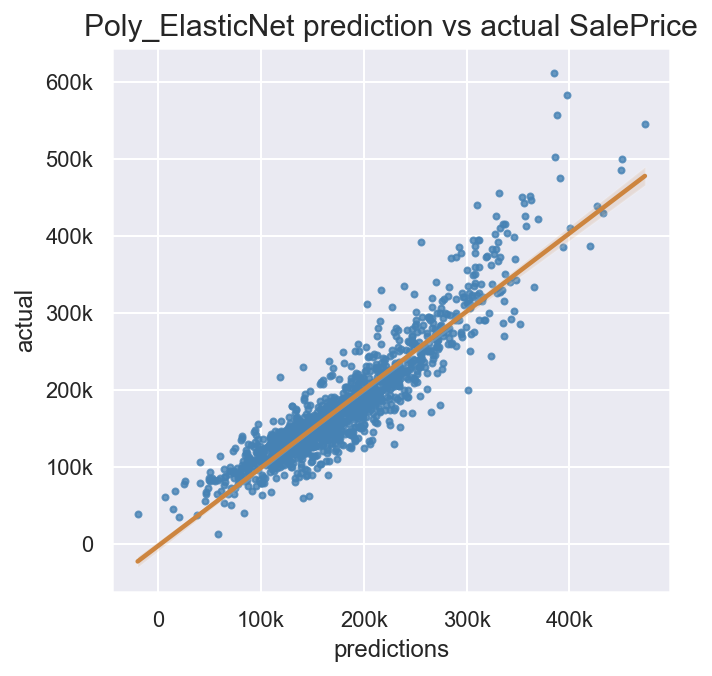

In [137]:
title = 'Poly_ElasticNet prediction vs actual SalePrice'
sns_plt(model=pipe12_gs, x_data=X_drop_train, y_data=y_train, title=title)

Deployed model is only reliable for house `SalePrice` recommendations that are \\$400k and below. I also noted that the model prediction has an outlying **negative** value, for an actual `SalePrice` value of about \$50k. This would need further investigation.

#### Evaluate for Multicollinearity:

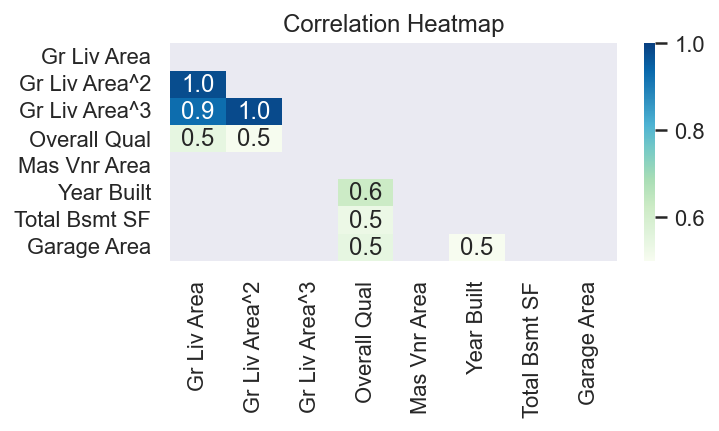

In [138]:
corr_heatmap(df=X_drop_train, size=(5,2))

There is some moderate multicollinearity between the features used for the deployed model for house `SalePrice` recommendation. Understandably, there is strong correlation between polynomial features and the root feature(`Gr Liv Area`)

In [139]:
vif_df2 = vif_scores(X_drop_train)

In [140]:
print(vif_df2)

         feature          vif
0    Gr Liv Area  7614.642484
1  Gr Liv Area^2  1466.996976
2  Gr Liv Area^3   412.389725
3   Overall Qual   366.169154
4   Mas Vnr Area     2.499063
5     Year Built     1.823990
6  Total Bsmt SF     1.701031
7    Garage Area     1.549491
8          const     1.314962


The VIF scores are reasonable, given that `Overall Qual` was already known to share multicollinearity with other features in the earlier evaluations. `Gr Liv Area` is the feature chosen for polynomial engineering, so multicollinearity is expected. 

##### Set up data file for model training in Streamlit web application: 

In [141]:
# join grp_X_train with y_train to provide data to model in streamlit 
# join grp_X_test with y_test to st_data
st_train = pd.concat([X_drop_train, y_train], axis=1)
st_test = pd.concat([X_drop_test, y_test], axis=1)

In [142]:
st_data = pd.concat([st_train, st_test], axis=0)

In [143]:
st_data.shape

(1994, 9)

In [144]:
st_data.to_csv('./local_app/streamlit_data.csv', index=False)

##### Set up data file for imputation fitting in Streamlit website: 

In [145]:
st_imp = pd.concat([X_drop_train, X_drop_test], axis=0)
st_imp.shape

(1994, 8)

In [146]:
st_imp.to_csv('./local_app/streamlit_imp_data.csv', index=False)

_**Preview predictions vs. actual `SalePrice`**_

In [147]:
# predicted SalePrice
pred_arr = pipe12_gs.predict(X_drop_train).round(2)

In [148]:
for i in range(5):
    print(f'Predicted Saleprice: {pred_arr[i]}')
    print(f'True Saleprice: {y_train[i]}')
    print()

Predicted Saleprice: 225399.46
True Saleprice: 174000

Predicted Saleprice: 176284.69
True Saleprice: 135000

Predicted Saleprice: 133652.76
True Saleprice: 144000

Predicted Saleprice: 316073.74
True Saleprice: 320000

Predicted Saleprice: 86293.36
True Saleprice: 108500



In [158]:
# to find the outlying negative predicted `SalePrice` value
for i in range(len(pred_arr)):
    if (pred_arr[i])<0:
        print(y_train[i])

39300


The actual `SalePrice` value \$39,300 was predicted negative by the deployed model. More investigation into the feature values that constitute this data point is required to find out why the deployed model would generate a **negative** `SalePrice` prediction for this particular data point.

## Limitations, Recommendations and Conclusion
---

__Limitations:__
1. The linear model that I chose as my final model for deployment is unable to predict accurately for house `SalePrices` above \$400k. 
1. The training data is outdated (collected 2006-2010), which may not reflect the current housing saleprice trends
1. The model does not account for external factors not related to property attributes but are closely associated with housing saleprices e.g. economic outlook, housing loan interest rates, unemployment rates, natural disaster, inflation, government incentives etc.
1. Part of the data was collected during the 2008 financial crisis, which could have pushed housing saleprices low.
1. The target variable `SalePrice` violates the line assumption. There is heteroscedasticity with variation increasing with `SalePrice`

__Recommendations:__
1. Target feature `SalePrice` has a right skewed distribution, which makes it difficult for the model to learn well on predicting houses with high `SalePrice`. We need more data of houses with saleprices above \\$400k to help the model predict better of houses that may be associated with high `SalePrice`. 
1. To optimise the model performance: 
    * I would like to take a more granular approach in identifying and excluding outliers. 
    * I would also prefer to collect a more complete set of data, more data or more recent training data e.g. 2020s.
    * I would get domain expert opinion on what features are well known to influence housing `SalePrice`. 
    * I would like to use other types of model, other than linear models for this data set. 

__Conclusion:__
1. Linear models may not be the best type of model for this data and target variable. I would like to use different models to get better `RMSE` performance and thus, more accurate house `SalePrice` recommendations. 
1. I would also like to consider other features that were not included in the provided data, to help resolve the multicollinearity problem. 

__Comments:__
1. I did not choose to use log transformation for any features as none seemed to show spread of data points suitable for log transformation.